In [3]:
import pandas as pd
import world_bank_data as wb #documentation: https://pypi.org/project/world-bank-data/
pd.set_option('display.max_rows', 21)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [26]:
# Indicators, all in % of GDP
indicators = {'elect_cons': 'EG.USE.ELEC.KH.PC', #electric power consumption
              'urb_pop': 'SP.URB.TOTL.IN.ZS', # urban population
              'gdp_cap': 'NY.GDP.PCAP.CD', # gdp per capita
              'school_enr':'SE.PRM.ENRR', # school enrollment, primary
              'tax_rev':'GC.TAX.TOTL.GD.ZS', # tax revenue
              'frgn_inv':'BX.KLT.DINV.CD.WD', # foreign investments
              'life_exp':'SP.DYN.LE00.IN', #life expetancy at birth
              'ad_fert':'SP.ADO.TFRT'} # adolescent fertility rate (15-19)

df = pd.DataFrame()

for i in indicators:
    ind_series = wb.get_series(indicators[i], country='ITA', date='1970:2020', id_or_value='id', simplify_index=True).rename(i).to_frame()
    if not df.empty:
        df = df.join(ind_series, how='outer')
    else:
        df = ind_series
        
# Check for nulls
df.isna().sum()

elect_cons    5
urb_pop       0
gdp_cap       0
school_enr    3
tax_rev       4
frgn_inv      0
life_exp      1
ad_fert       1
dtype: int64

In [34]:
# Fill nulls with next values
df = df.fillna(method='bfill')
df.isna().sum()

elect_cons    0
urb_pop       0
gdp_cap       0
school_enr    0
tax_rev       0
frgn_inv      0
life_exp      0
ad_fert       0
dtype: int64

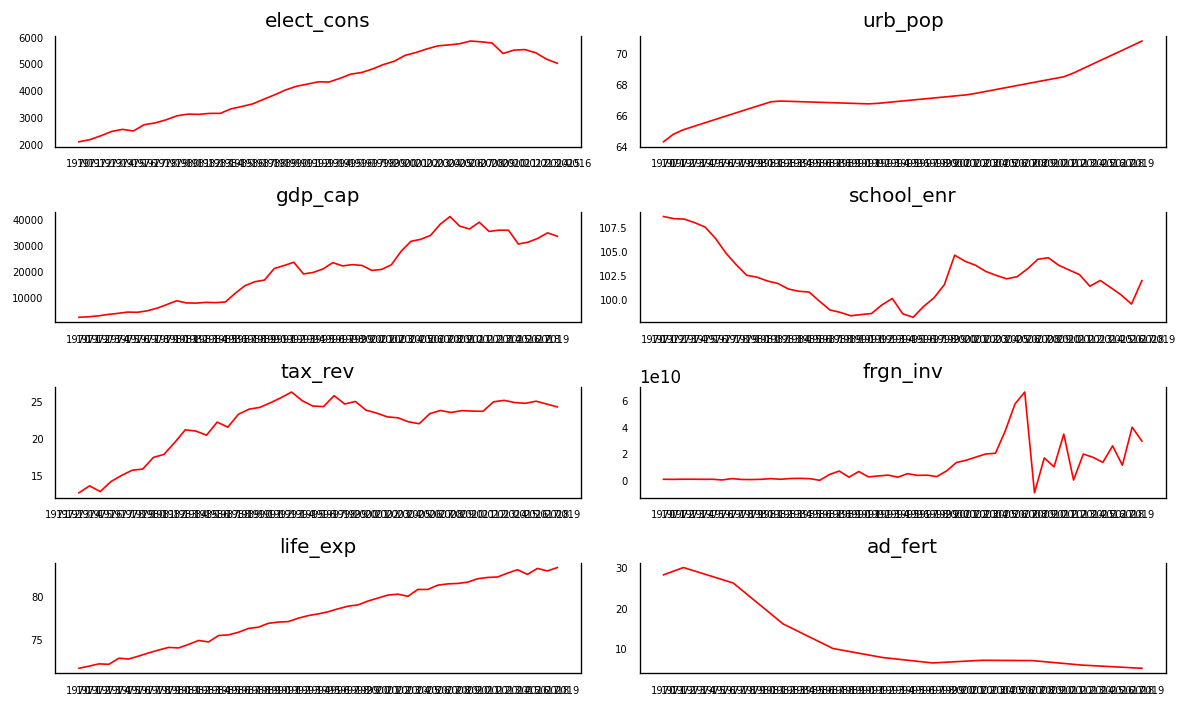

In [27]:
# Vizualize time series
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


In [35]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

,elect_cons_x,urb_pop_x,gdp_cap_x,school_enr_x,tax_rev_x,frgn_inv_x,life_exp_x,ad_fert_x
elect_cons_y,1.0000,0.0366,0.0000,0.0000,0.0000,0.0000,0.0000,0.0207
urb_pop_y,0.0000,1.0000,0.0035,0.0000,0.0000,0.0000,0.0294,0.0000
gdp_cap_y,0.0000,0.1891,1.0000,0.0000,0.0000,0.0000,0.0000,0.0945
school_enr_y,0.0000,0.0000,0.1275,1.0000,0.0000,0.0023,0.0000,0.0803
tax_rev_y,0.0009,0.0000,0.0000,0.0006,1.0000,0.0023,0.3255,0.0000
frgn_inv_y,0.0005,0.0034,0.0001,0.0000,0.0002,1.0000,0.0000,0.0263
life_exp_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0646
ad_fert_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0366,0.0000,1.0000


In [43]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(46, 8)
(4, 8)


In [44]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    
        
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "elect_cons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0131
 No. Lags Chosen       = 1
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.2808. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "urb_pop" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8596
 No. Lags Chosen       = 2
 Critical value 1%     = -3.593
 Critical value 5%     = -2.932
 Critical value 10%    = -2.604
 => P-Value = 0.9925. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "gdp_cap" 
    -----------------------------------------------
 Null Hypothesis: Data h

In [45]:
# 1st difference
df_differenced = df_train.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "elect_cons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.3379
 No. Lags Chosen       = 0
 Critical value 1%     = -3.589
 Critical value 5%     = -2.93
 Critical value 10%    = -2.603
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "urb_pop" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3251
 No. Lags Chosen       = 1
 Critical value 1%     = -3.593
 Critical value 5%     = -2.932
 Critical value 10%    = -2.604
 => P-Value = 0.6176. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "gdp_cap" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

In [46]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "elect_cons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8116
 No. Lags Chosen       = 6
 Critical value 1%     = -3.621
 Critical value 5%     = -2.944
 Critical value 10%    = -2.61
 => P-Value = 0.0566. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "urb_pop" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0524
 No. Lags Chosen       = 1
 Critical value 1%     = -3.597
 Critical value 5%     = -2.933
 Critical value 10%    = -2.605
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gdp_cap" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

In [48]:
# Third Differencing
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "elect_cons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7294
 No. Lags Chosen       = 6
 Critical value 1%     = -3.627
 Critical value 5%     = -2.946
 Critical value 10%    = -2.612
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "urb_pop" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9194
 No. Lags Chosen       = 3
 Critical value 1%     = -3.61
 Critical value 5%     = -2.939
 Critical value 10%    = -2.608
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "gdp_cap" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Le

In [49]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  67.19842778381076
BIC :  70.17728998658224
FPE :  1.611931627487252e+29
HQIC:  68.29029859697188 

Lag Order = 2
AIC :  64.20222220863424
BIC :  69.88626613721439
FPE :  1.16743228038454e+28
HQIC:  66.27203761878559 

Lag Order = 3
AIC :  58.78436191502511
BIC :  67.22875918559478
FPE :  1.911419285506664e+26
HQIC:  61.83758932465747 

Lag Order = 4
AIC :  17.64206675380069
BIC :  28.903099435293683
FPE :  26038926115.783962
HQIC:  21.68242837532179 

Lag Order = 5
AIC :  -117.213757227358
BIC :  -103.07880300656184
FPE :  9.150914796143898e-48
HQIC:  -112.18464856700766 

Lag Order = 6
AIC :  -145.22684609261702
BIC :  -128.15982388298093
FPE :  3.706566689468435e-66
HQIC:  -139.2099213517469 

Lag Order = 7
AIC :  -120.05614524212193
BIC :  -99.99823868834454
FPE :  1.0672372090663197e-58
HQIC:  -113.0553986214426 

Lag Order = 8
AIC :  -116.5475294950643
BIC :  -93.43950115293586
FPE :  4.5954781304544694e-60
HQIC:  -108.57064136087261 

Lag Order = 9
AIC :  -11

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [50]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,68.71,69.08,6.923e+29,68.83
1,66.18,69.51,6.344e+28,67.27
2,61.73,68.02,1.894e+27,63.78
3,15.74,24.99,9.799e+08,18.75
4,-130.1,-117.9,1.376e-52,-126.1
5,-140.7,-125.5,3.636e-64,-135.8
6,-152.1,-134.0,1.397e-72,-146.2
7,-150.1,-129.0,1.820e-74,-143.3
8,-148.7,-124.6,2.855e-76,-140.9
9,-137.7,-110.6,1.013e-73,-128.8


In [51]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,68.71,69.08,6.923e+29,68.83
1,66.18,69.51,6.344e+28,67.27
2,61.73,68.02,1.894e+27,63.78
3,15.74,24.99,9.799e+08,18.75
4,-130.1,-117.9,1.376e-52,-126.1
5,-140.7,-125.5,3.636e-64,-135.8
6,-152.1,-134.0,1.397e-72,-146.2
7,-150.1,-129.0,1.820e-74,-143.3
8,-148.7,-124.6,2.855e-76,-140.9
9,-137.7,-110.6,1.013e-73,-128.8


In [53]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Jul, 2020
Time:                     09:56:18
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    28.9031
Nobs:                     39.0000    HQIC:                   21.6824
Log likelihood:          -522.729    FPE:                2.60389e+10
AIC:                      17.6421    Det(Omega_mle):     1.92966e+08
--------------------------------------------------------------------
Results for equation elect_cons
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -4.620655         7.958697           -0.581           0.562
L1.elect_cons        -0.964914         0.182239           -5.295           0.000
L1.urb_pop          724.459189       589.080955        

In [56]:
def adjust(val, length= 6): return str(val).ljust(length)

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

elect_cons : 0.97
urb_pop : 1.36
gdp_cap : 1.22
school_enr : 1.11
tax_rev : 1.53
frgn_inv : 1.51
life_exp : 0.73
ad_fert : 1.44


In [57]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[-3.39268241e+01,  1.24000000e-01, -9.82185869e+03,
        -7.25880000e-01,  1.30298593e+00, -9.01772366e+10,
         1.48780488e-01,  0.00000000e+00],
       [ 1.66590312e+01, -6.80000000e-02,  1.01860625e+04,
         2.54081000e+00, -2.43944054e+00,  1.12892653e+11,
         5.00000000e-01,  9.02000000e-02],
       [ 2.03276532e+02, -5.70000000e-02, -4.56999227e+03,
        -3.16898000e+00,  6.17260459e-01, -7.59222706e+10,
        -4.51219512e-01, -9.02000000e-02],
       [ 7.49961280e+01,  2.00000000e-03, -4.72862173e+03,
         1.33242000e+00,  6.86192602e-01,  2.07645420e+10,
        -8.95121951e-01,  1.77635684e-15]])

In [58]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,elect_cons_2d,urb_pop_2d,gdp_cap_2d,school_enr_2d,tax_rev_2d,frgn_inv_2d,life_exp_2d,ad_fert_2d
Year,,,,,,,,
2016,-362.753326,0.254155,6920.937455,0.780571,-0.174186,-4.694682e+10,2.084721,0.593659
2017,-280.605913,-0.243595,-9515.382412,-2.115451,-3.066973,2.151614e+11,-2.208464,-1.634741
2018,1517.773338,-0.061192,27384.029143,-0.197322,3.652292,-3.947190e+11,2.294882,1.745715
2019,-2249.793547,0.112893,-40294.361570,3.014955,3.247538,4.493218e+11,-3.581327,0.763199


In [64]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc


df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['elect_cons_forecast', 'urb_pop_forecast', 'gdp_cap_forecast', 'school_enr_forecast',
                   'tax_rev_forecast', 'frgn_inv_forecast', 'life_exp_forecast', 'ad_fert_forecast']]


,elect_cons_forecast,urb_pop_forecast,gdp_cap_forecast,school_enr_forecast,tax_rev_forecast,frgn_inv_forecast,life_exp_forecast,ad_fert_forecast
Year,,,,,,,,
2016,4639.653353,70.112155,31862.974768,100.402651,24.463796,-3.737269e+10,84.082282,5.964459
2017,3996.294114,70.415715,23980.340822,98.303101,21.121092,1.271125e+11,83.412199,4.792577
2018,4870.708213,70.658084,43481.736020,96.006229,21.430680,-1.031212e+11,85.036997,5.366411
2019,3495.328765,71.013345,22688.769647,96.724312,24.987806,1.159668e+11,83.080468,6.703443


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/usr/local/lib/python3.8/site-packages/pandas/plot

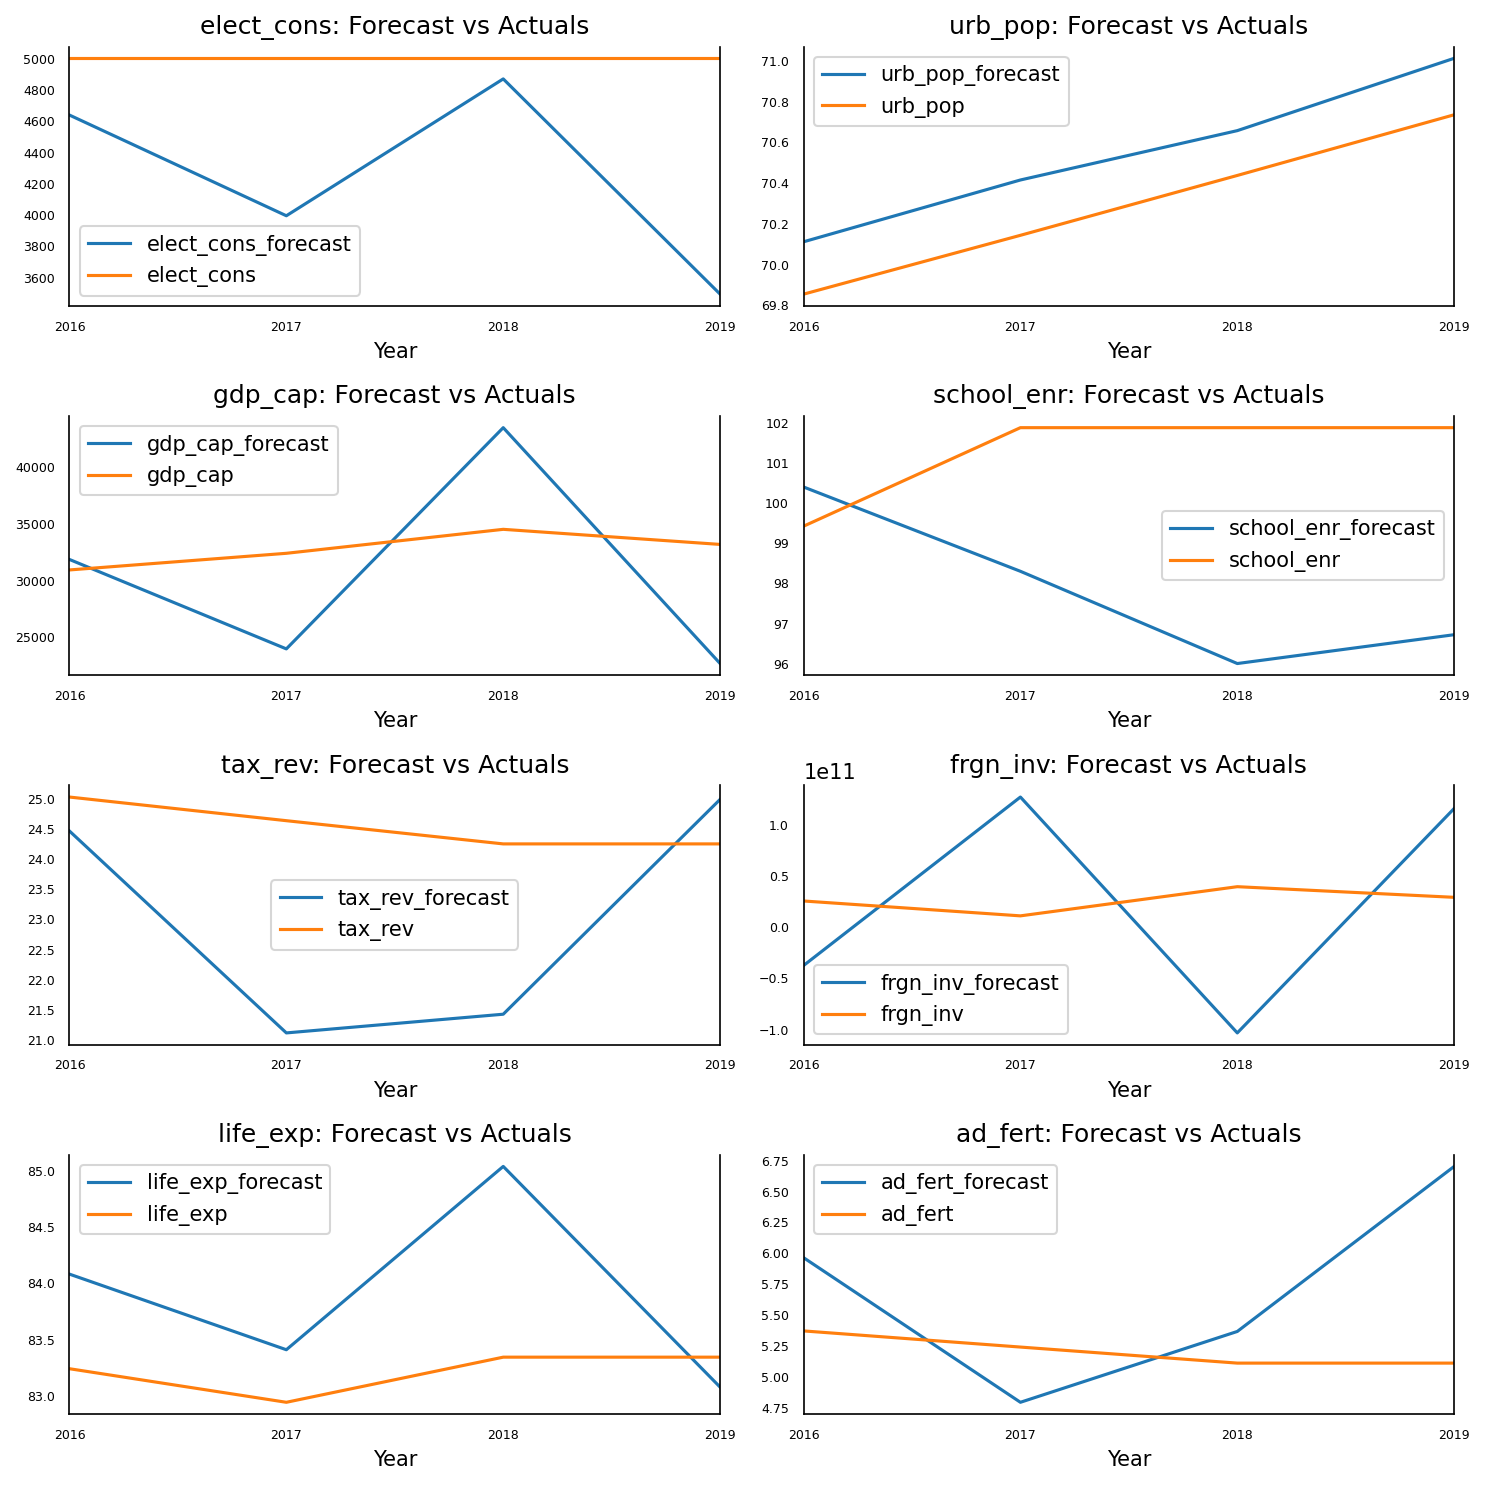

In [65]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [68]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: elect_cons')
accuracy_prod = forecast_accuracy(df_results['elect_cons_forecast'].values, df_test['elect_cons'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: urb_pop')
accuracy_prod = forecast_accuracy(df_results['urb_pop_forecast'].values, df_test['urb_pop'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdp_cap')
accuracy_prod = forecast_accuracy(df_results['gdp_cap_forecast'].values, df_test['gdp_cap'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: school_enr')
accuracy_prod = forecast_accuracy(df_results['school_enr_forecast'].values, df_test['school_enr'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: tax_rev')
accuracy_prod = forecast_accuracy(df_results['tax_rev_forecast'].values, df_test['tax_rev'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: frgn_inv')
accuracy_prod = forecast_accuracy(df_results['frgn_inv_forecast'].values, df_test['frgn_inv'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: life_exp')
accuracy_prod = forecast_accuracy(df_results['life_exp_forecast'].values, df_test['life_exp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ad_fert')
accuracy_prod = forecast_accuracy(df_results['ad_fert_forecast'].values, df_test['ad_fert'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: elect_cons
mape   :  0.1503
me     :  -751.9106
mae    :  751.9106
mpe    :  -0.1503
rmse   :  926.3478
corr   :  nan
minmax :  0.1503

Forecast Accuracy of: urb_pop
mape   :  0.0037
me     :  0.2566
mae    :  0.2566
mpe    :  0.0037
rmse   :  0.2575
corr   :  0.9977
minmax :  0.0036

Forecast Accuracy of: gdp_cap
mape   :  0.2165
me     :  -2260.5661
mae    :  7203.0218
mpe    :  -0.0717
rmse   :  8099.9103
corr   :  0.4502
minmax :  0.2029

Forecast Accuracy of: school_enr
mape   :  0.0383
me     :  -3.4068
mae    :  3.8954
mpe    :  -0.0334
rmse   :  4.3247
corr   :  -0.8704
minmax :  0.0383

Forecast Accuracy of: tax_rev
mape   :  0.0779
me     :  -1.5397
mae    :  1.9083
mpe    :  -0.0627
rmse   :  2.2999
corr   :  0.1846
minmax :  0.0777

Forecast Accuracy of: frgn_inv
mape   :  4.8601
me     :  -760892272.3575
mae    :  102121047146.9286
mpe    :  1.8302
rmse   :  106443342757.1158
corr   :  -0.7319
minmax :  1.9301

Forecast Accuracy of: life_exp
mape   : 

/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
